# Project 2: Republication report 

## Introduction

In this project, we attempt replicating the figure 2.a from the article "Friendship and Mobility: User Movement in Location-Based Social Networks ". The figure represents the relation between the probability of friendship and the distance between their houses. To replicate it, we will first find the position of the houses of each user by using the method described in the article and then assign a distance between each user and his friends. Finally, we will be able to calculate the probability of occurrence for all the distance and replicate the figure. More details are provided in the following sections. The article can be found at this address: https://drive.google.com/drive/folders/1QRoC6DAMoD_BxJ6KPMdijBRTDUYhoVfG?usp=sharing

## Importing packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # needed for plotting
import geopandas as gpd # for Geo-location filtering
from netCDF4 import Dataset as nc  # for loading standard climate date format (nc extension)
import netCDF4 # for loading standard climate date format (nc extension)
import xarray as xr # for handling climate data
from pandarallel import pandarallel # for running pandas functions in parallel
import multiprocessing # for general parallelizing of codes
import tqdm # for having progres bar
from functools import partial # for full control over handling function arguemnts
pandarallel.initialize(nb_workers=multiprocessing.cpu_count()-1)

/home/afalsafi/.local/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


INFO: Pandarallel will run on 23 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Loading the data

In [2]:
# Data of two set of data
DATA_FOLDER = 'Data/'

INP_FOLDER = 'InputData/'

# Friendship undirected network users and Time and location information of check-ins made by users

#Brightkite
BRIGHT_NETWORK_DATASET = DATA_FOLDER + "Brightkite_edges.txt.gz"
BRIGHT_CHECKIN_TIME_LOCATION_DATASET = DATA_FOLDER + "Brightkite_totalCheckins.txt.gz"

#Gowalla
GOWALLA_NETWORK_DATASET = DATA_FOLDER + "Gowalla_edges.txt.gz"
GOWALLA_CHECKIN_TIME_LOCATION_DATASET = DATA_FOLDER + "Gowalla_totalCheckins.txt.gz"

# loading all the data set
b_network_df = pd.read_csv(BRIGHT_NETWORK_DATASET, delimiter="\t",
                                    error_bad_lines =False, header = 0 )
b_checkin_df = pd.read_csv(BRIGHT_CHECKIN_TIME_LOCATION_DATASET, delimiter="\t",
                                       error_bad_lines =False, header = 0 )
g_network_df = pd.read_csv(GOWALLA_NETWORK_DATASET, delimiter = "\t",header = None)
g_checkin_df = pd.read_csv(GOWALLA_CHECKIN_TIME_LOCATION_DATASET, delimiter = "\t",header = None)

In [3]:
#Set up the header 
NETWORK_COLUMNS = ['user','friend_edge']
CHECKIN_COLUMNS = ['user','checkin_time','latitude','longitude','location_id']

In [4]:
#Rename the columns

b_network_df.columns = NETWORK_COLUMNS
b_checkin_df.columns = CHECKIN_COLUMNS
g_network_df.columns = NETWORK_COLUMNS
g_checkin_df.columns = CHECKIN_COLUMNS

In [5]:
b_network_df.sample(3)

,user,friend_edge
269163,13880,760
233169,10665,10777
283469,15342,7710


In [6]:
b_checkin_df.sample(3)

,user,checkin_time,latitude,longitude,location_id
359197,721,2009-07-10T02:48:16Z,37.444825,-122.161383,930877426ce511de9a23003048c10834
876389,2611,2008-06-19T16:53:08Z,35.994033,-78.898619,ec215acea22411ddae3c9b54cfc40101
1528328,6225,2009-07-09T14:27:45Z,51.474005,-0.206921,498386066c8c11deb236003048c10834


In [7]:
g_network_df.sample(3)

,user,friend_edge
252840,2572,4370
1856037,173776,104290
194258,1821,54042


In [8]:
g_checkin_df.sample(3)

,user,checkin_time,latitude,longitude,location_id
37504,158,2010-07-30T00:51:17Z,37.377049,-122.076223,239576
1448977,9794,2010-05-19T16:43:54Z,42.298188,-71.421914,403278
6260032,175952,2010-10-07T23:18:02Z,18.312317,-66.079829,5107639


---------------------------

## Pre-process

At first, before starting our recollection, we need to pre-process our dataset. So, we can begin by counting all the null values and remove them if necessary. We also want the latitude and longitude to be respectively in the interval [-90,90] and [-180,180].

In [9]:
g_checkin_df.isnull().sum()

user            0
checkin_time    0
latitude        0
longitude       0
location_id     0
dtype: int64

In [10]:
b_checkin_df.isnull().sum()

user            0
checkin_time    6
latitude        6
longitude       6
location_id     6
dtype: int64

In [11]:
'''Cleaning the data'''

# locate rows with NaN
rows_with_NaN_b = b_checkin_df.loc[(b_checkin_df['latitude'].isna() == True)]
rows_with_NaN_g = g_checkin_df.loc[(g_checkin_df['latitude'].isna() == True)]

# locate rows that are not in those interval : -90 < Latitude < 90 and -180 < Longitude < 180

# latitude
lat_to_removed_b = b_checkin_df.loc[(b_checkin_df['latitude'] > 90) | (b_checkin_df['latitude'] < -90)]
lat_to_removed_g = g_checkin_df.loc[(g_checkin_df['latitude'] > 90) | (g_checkin_df['latitude'] < -90)]

# longitude
long_to_removed_b = b_checkin_df.loc[(b_checkin_df['longitude'] > 180) | (b_checkin_df['longitude'] < -180)]
long_to_removed_g = g_checkin_df.loc[(g_checkin_df['longitude'] > 180) | (g_checkin_df['longitude'] < -180)]

# Dropping all the rows

# Brightkite
b_checkin_df = b_checkin_df.drop(rows_with_NaN_b.index)
b_checkin_df = b_checkin_df.drop(lat_to_removed_b.index)
b_checkin_df = b_checkin_df.drop(long_to_removed_b.index)

#see bellow
b_checkin_df = b_checkin_df.drop(b_checkin_df[b_checkin_df['location_id'] == '00000000000000000000000000000000'].index)

# Gowalla
g_checkin_df = g_checkin_df.drop(rows_with_NaN_g.index)
g_checkin_df = g_checkin_df.drop(lat_to_removed_g.index)
g_checkin_df = g_checkin_df.drop(long_to_removed_g.index)

Note that some weird values were spotted for the bright kite dataset on the position (0,0) with a "location_id" equal to " 00000...0000 ". As quoted on page 1083 of our article: " The total number of check-ins for Gowalla is 6.4 million and 4.5 million for Brightkite. " So to be more consistent with those numbers we decide to also remove them. We can now show the shape of our two datasets.

In [12]:
# Number of the check-ins used in the recollection 
print('The total number of check-ins for Gowalla :',g_checkin_df.shape[0])
print('The total number of check-ins for Brightkite :',b_checkin_df.shape[0])

The total number of check-ins for Gowalla : 6442863
The total number of check-ins for Brightkite : 4492552


-------------------------------------------------------------------------

## Data Recollection 

### Classing every check-ins in cells of 25x25 km 
In the next two sections, we will provide more details on the method described in the paper.
So, we begin by classing every check-in in a grid of 25x25 km over the world. One way of classing into cells is to perform euclidean division by 25 on both latitude and longitude. Then we can use the quotient of those divisions to identify our cells.
As we have two dimensions, we find two sets of intervals ( one on latitude and one on longitude) with the origin of the gird on (0,0). Both sets can be either positive or negative to map all the four earth's dial. Thus, two "check-ins" with the same latitude and longitude intervals will be classified in the same cell. Note that to do a euclidean division by 25 km, we need to transform all latitudes and longitudes into kilometers and take into account the distortion of the earth. This is performed by two functions which follow the formula from this website :
https://stackoverflow.com/questions/1253499/simple-calculations-for-working-with-lat-lon-and-km-distance

In [13]:
def lat_degree_to_km(latitude):
    '''
    Input : Latitude in degree
    Output : Latitude in km
    
    '''
    return latitude * 110.574
    

In [14]:
def long_degree_to_km(latitude,longitude):
    '''
    Input : Longitude , Latitude in degree
    Output : Longitude in km  
    
    '''
    return 111.320 * np.cos((latitude * np.pi) / 180) * longitude

In [15]:
def classing_into_cells(g_checkin_df):
    '''
    Input : the time and location information of check-ins made by users
    Output : check-in dataset classified by cells
    
    '''
    # Creation of columns regrouping km for longitude and latitude with the two function see above
    
    g_checkin_df['lat_km'] = lat_degree_to_km(g_checkin_df['latitude']) 
    g_checkin_df['long_km'] = long_degree_to_km(g_checkin_df['latitude'],g_checkin_df['longitude'])
    
    # creation of cells with size 25 x 25 km represented by two sets of intervals int_longitude and int_latitude. 
    # By taking those two together we can build a grid with an origin at (0,0)
    # Note that when the interval is transfering from float to int he takes the floor number for 
    # positive number and the ceil number for the negative interval, that's what we want .
    
    g_checkin_df['int_lat'] = (g_checkin_df['lat_km'] / 25).astype(int)
    g_checkin_df['int_long'] = (g_checkin_df['long_km'] / 25).astype(int)
    
    return g_checkin_df

In [16]:
g_checkin_df = classing_into_cells(g_checkin_df)
b_checkin_df = classing_into_cells(b_checkin_df)

In [17]:
g_checkin_df.sample(3)

,user,checkin_time,latitude,longitude,location_id,lat_km,long_km,int_lat,int_long
1965344,16596,2010-08-30T16:47:41Z,59.364421,17.880710,408236,6564.161515,1014.300803,262,40
927165,4216,2010-09-18T18:58:40Z,30.266891,-97.745686,9223,3346.731165,-9397.820744,133,-375
2921719,36701,2010-06-08T18:01:00Z,33.019745,-96.700408,72878,3651.125278,-9026.007183,146,-361


In [18]:
b_checkin_df.sample(3)

,user,checkin_time,latitude,longitude,location_id,lat_km,long_km,int_lat,int_long
996876,2902,2010-01-04T04:21:20Z,35.664619,139.731586,388a0e0d5f3c9c758d3b7d21262b916e,3943.579581,12637.497154,157,505
100190,163,2008-10-19T01:46:49Z,37.977978,-122.031073,ee6dfa4ea22411ddb437d387fe6e2755,4199.376939,-10707.945087,167,-428
3594965,19750,2008-07-02T05:28:16Z,43.700114,-79.416304,ef30fa30a22411ddaa4273c6ec231196,4832.096405,-6391.467798,193,-255


-----------------------------------------

### Finding the location of the users (latitude, longitude)

Now we want to find the location of the user's houses. Thus, we assume that the position of the house of the user will be at the mean of all the check-ins positions (latitude and longitude) appearing in one particular cell.
This particular cell is established by analyzing all cells linked to one user and pick the one that has the most number of check-ins in it. The article claims that this method is known to be accurate at 85 %.

##### Method:
Here, we use the function "groupby" to get a new dataset that grouped for each user all his check-ins by cells by counting how many rows appear to have the same "int_lat", "int_long" and "user". So then, we can sort all counts by users to take only the top one with the highest number of check-ins. We merge this dataset to the one classified by cells. Then, by comparing all check-ins cells and the previous result we can find the rows representing the cell with the most check-ins. Finally, the location of the house will be the average position of all the check-ins contained in this particular cell. 

Note that in the paper "Friendship and Mobility: User Movement in Location-Based Social Networks", any information was provided on how to deal with users that had the same number of check-ins on all his cells. For them, we decide to just take the cell located at the top of the user's groupby after sorting it without any further research.


In [19]:
def find_user_house(g_checkin_df):
    '''
    Input : check-in dataset classified by cells
    Output : dataset link each user's with his house location (latitude, longitude)
    
    '''
    # finding intervals that has the highest number of check-ins in it
    
    int_house_users = g_checkin_df.groupby(['user','int_lat','int_long']).count()
    int_house_users = int_house_users['checkin_time'].sort_values(
        ascending = False).groupby(level = 0).head(1).reset_index()
    int_house_users = int_house_users.rename(
        {'int_lat' : 'house_int_latitude','int_long' : 'house_int_longitude'},
        axis = "columns")
    
    # finding all the check-ins made in those intervals (cells)
    
    house_users = g_checkin_df.merge(int_house_users,
                    left_on = ['user'],
                    right_on = ['user'])
    
    house_users = house_users.loc[(house_users['int_lat'] == house_users['house_int_latitude'])
                            & (house_users['int_long'] == house_users['house_int_longitude'])]
    
    #finding latitude and longitude of the user's house.
    
    houses = house_users.groupby(['user']).mean()[['latitude','longitude']].rename(
        { 'latitude':'user_house_lat' ,'longitude':'user_house_long'},
        axis = "columns")
    return houses

In [20]:
houses_gowalla = find_user_house(g_checkin_df)
houses_bright = find_user_house(b_checkin_df)

----------------------

### Matching the houses of the users and their friends 

By using the result from the last section, we have at our disposal two data set which maps all users with the location of their houses. In addition to this, we also have the two Friendship undirected network initially provided. As stated in the introduction, our goal is to find the distance between each user and his friends. In order to do that we match the two networks ("g_network_df" and "b_network_df") with both the location of their user's houses and the location of the friend's houses in one dataset. Then, we can calculate the distance for each row by the following method of the sinus:
http://villemin.gerard.free.fr/aGeograp/Distance.htm

In [21]:
def dist_km(Lat_start,Long_start,Lat_end,Long_end):
    '''
    Input : latitude and longitude of a point A and B
    Output : Distance between A and B
    
    '''
    # Calcul with the method of sinus
    distance_km = np.arccos(np.sin(np.pi * Lat_start / 180.0) * np.sin(np.pi * Lat_end / 180.0) \
                          + np.cos(np.pi * Lat_start / 180.0) * np.cos(np.pi * Lat_end / 180.0) \
                            * np.cos(np.pi * Long_start / 180.0 - np.pi * Long_end / 180.0)) * 6371
    return distance_km

In [22]:
def matching_user_friend(houses,network_df):
    '''  
    
    Input: two dataset one containing the dataset which link each user's with his house location (latitude, longitude)
    and one other containing the friendship network of users
    Output: one dataset with the location of both users and their friends and with the distance linking the both houses
    
    '''
    
    # merge the location of the friends houses to the network data set
    
    friend_house_location = houses.reset_index().rename({'user':'friend_edge'},axis = 'columns')
    friend_house_location = network_df.merge(friend_house_location,
                                           on = 'friend_edge').rename(
        {'user_house_lat' : 'friend_house_lat','user_house_long' : 'friend_house_long'},
        axis = "columns")
    
    # merge the location of the users houses to this same dataset

    network_houses_locations_df = friend_house_location.merge(houses, on ='user')
    
    # calculate the distance between each users and their friends
    
    network_houses_locations_df['dist_btw_user_friend'] = dist_km(network_houses_locations_df['user_house_lat'],
                                                                  network_houses_locations_df['user_house_long']
                                                              ,network_houses_locations_df['friend_house_lat'],
                                                                  network_houses_locations_df['friend_house_long'])
    
    return network_houses_locations_df

In [23]:
g_network_houses_locations_df = matching_user_friend(houses_gowalla, g_network_df)

/home/afalsafi/.local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [24]:
b_network_houses_locations_df = matching_user_friend(houses_bright,b_network_df) 
# Here we have an error for the rows that are combining a user and a friend that live in the same cell so
# we are simply replacing the Nan values by zero to take those values into account.
b_network_houses_locations_df['dist_btw_user_friend'].loc[b_network_houses_locations_df['dist_btw_user_friend'].isna()] = 0

/home/afalsafi/.local/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [25]:
g_network_houses_locations_df.sample(3)

,user,friend_edge,friend_house_lat,friend_house_long,user_house_lat,user_house_long,dist_btw_user_friend
0,0,1,45.202484,-0.746831,30.263544,-97.744633,8176.385471
1,0,2,34.061224,-118.307591,30.263544,-97.744633,1977.484474
2,0,4,37.787660,-122.406340,30.263544,-97.744633,2412.983086
3,0,5,30.274974,-97.726415,30.263544,-97.744633,2.162484
4,0,7,30.268433,-97.743261,30.263544,-97.744633,0.559443
...,...,...,...,...,...,...,...
913655,196480,196478,1.297822,103.849685,1.329142,103.879588,4.814444
913656,196480,196479,1.384787,103.876391,1.329142,103.879588,6.197671
913657,196478,196479,1.384787,103.876391,1.297822,103.849685,10.115484
913658,196478,196480,1.329142,103.879588,1.297822,103.849685,4.814444


In [26]:
b_network_houses_locations_df.sample(3)

,user,friend_edge,friend_house_lat,friend_house_long,user_house_lat,user_house_long,dist_btw_user_friend
0,0,2,39.738340,-104.960762,39.746676,-104.973602,1.436861
1,0,3,37.670403,-122.406295,39.746676,-104.973602,1527.636902
2,0,4,60.173672,24.942450,39.746676,-104.973602,8004.049318
3,0,5,37.635941,-122.385039,39.746676,-104.973602,1526.759839
4,0,6,41.925804,-87.700002,39.746676,-104.973602,1470.644415
...,...,...,...,...,...,...,...
388176,58225,58226,33.833333,35.833333,33.833333,35.833333,0.000000
388177,58225,58227,33.833333,35.833333,33.833333,35.833333,0.000000
388178,58226,58220,33.853940,35.577409,33.833333,35.833333,23.746457
388179,58226,58225,33.833333,35.833333,33.833333,35.833333,0.000000


------------------------------

### Replication:




Here we attempt to plot a figure similar to the one from the paper. At first, we rounded each distance over to the closest kilometer, but the obtained result was showing a lot of noises for high distance. So, to get rid of this issue, we decide to round all distance over a logarithmic scale. The rounding and probability are calculated through the NumPy function "np.histogram". 

In [27]:
# set logarithmic scale for rounding
bins = np.logspace(0,5,75,endpoint = True)

# rounding and calcul of the probability
proba_g, bins = np.histogram(g_network_houses_locations_df['dist_btw_user_friend'].values, bins = bins ,density = True)
proba_b, bins = np.histogram(b_network_houses_locations_df['dist_btw_user_friend'].values, bins = bins ,density = True)

Text(0.5, 1.0, '(a) Friends')

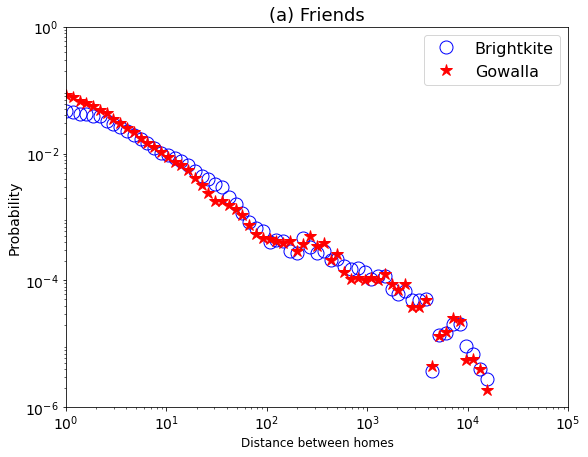

In [28]:
# plot of the result

plt.figure(figsize = (9,7), facecolor = 'none')
plt.loglog(bins[:-1], proba_b,marker = "o",color ='none',linewidth = 0,markersize = 13,markeredgecolor = "b")
plt.loglog(bins[:-1], proba_g,marker = "*",color ='r',linewidth = 0,markersize = 13 ,markeredgecolor = "r")
plt.xscale('log')
plt.yscale('log')
plt.xlim((1,1e5))
plt.ylim((1e-6,1))
plt.legend(['Brightkite','Gowalla'],fontsize = 16)
plt.xlabel('Distance between homes',fontsize = 12)
plt.ylabel('Probability',fontsize = 14)
plt.xticks(np.logspace(0,5,6),fontsize = 14)
plt.yticks(np.logspace(-6,0,4),fontsize = 14)
plt.title('(a) Friends',fontsize = 18)

## Conclusion


As you can see above, a similar figure was found with some small differences, but those can depend a lot on which rounding we took to calculate our probability. So a perfect replication will be difficult to find because the rounding used in the paper was not provided. Note that those discrepancies could also be caused by the differences in the formula that can be used to calculate the distance between two points on the Earth (Methods of the sinus, Pythagore, or the Haversine). Nevertheless, we still have similar curves and the same proportion on both axes. We can also see a similar kink between the distance $10^2$ [km] and $10^3$ [km] in both figures and around $10^4$ [km] we have the same nonlinear repartition of probability.But, above all the paper's hypothesis that two people living very far away from each other are unlikely to be friends is verified and we have two independent datasets (Gowalla and Brightkite) that give the same result.


-----------------------------------------------------

# Loading new data set 

In [29]:
import geopandas as gpd

In [30]:
houses_gowalla = houses_gowalla.reset_index()
houses_bright = houses_bright.reset_index()

Making geodataframe with the user home

In [31]:
gdf_home = gpd.GeoDataFrame(
    houses_gowalla, geometry=gpd.points_from_xy(houses_gowalla.user_house_long,houses_gowalla.user_house_lat))
gdf_home_b = gpd.GeoDataFrame(
    houses_bright, geometry=gpd.points_from_xy(houses_bright.user_house_long,houses_bright.user_house_lat))

In [32]:
gdf_home.sample(3)

,user,user_house_lat,user_house_long,geometry
16006,22882,37.746709,-122.355752,POINT (-122.35575 37.74671)


Import the shape file from https://www.igismap.com/united-states-shapefile-download-free-map-boundary-states-and-county/ called Download Polygon Shapefile of United States of America you can find the link for the download here https://map.igismap.com/share-map/export-layer/Alabama_AL4_US_Poly/1534b76d325a8f591b52d302e7181331

In [33]:
#import shp
states =gpd.read_file(INP_FOLDER + 'United_States-_States_Polygon.shp') 

Then we can join our user by states

In [34]:
from geopandas.tools import sjoin
gdf_home.crs = "EPSG:4326"
gdf_home_b.crs = "EPSG:4326"

In [35]:
def sjoin_chunk(chunk):
    chunk.crs = "EPSG:4326"
    return sjoin(chunk, states, how='left')

In [36]:
def parallelize_dataframe_func(df, func):
    num_cores = multiprocessing.cpu_count()-1  #leave one free to not freeze machine
    num_partitions = num_cores #number of partitions to split dataframe
    df_split = np.array_split(df, num_partitions)
    pool = multiprocessing.Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [37]:
pointInStates = parallelize_dataframe_func(gdf_home, sjoin_chunk)
pointInStates_b = parallelize_dataframe_func(gdf_home_b, sjoin_chunk)


In [38]:
#pointInStates= sjoin(gdf_home, states, how='left')
#pointInStates_b = sjoin(gdf_home_b,states, how='left')

In [39]:
gdf_home.shape

(107092, 4)

We clear the user outside the USA

In [40]:
pointInStates = pointInStates.loc[pointInStates['country']=='USA']
pointInStates_b = pointInStates_b.loc[pointInStates_b['country']=='USA']

Data cleaning to have only what we want

In [41]:
pointInStates = pointInStates[['user','user_house_lat','user_house_long','name']]
pointInStates_b = pointInStates_b[['user','user_house_lat','user_house_long','name']]
user_in_usa_g = pointInStates['user']
user_in_usa_b = pointInStates_b['user']
gdf_home_plot = gpd.GeoDataFrame(pointInStates, geometry=gpd.points_from_xy(pointInStates.user_house_long,pointInStates.user_house_lat))
gdf_home_plot_b = gpd.GeoDataFrame(pointInStates_b, geometry=gpd.points_from_xy(pointInStates_b.user_house_long,pointInStates_b.user_house_lat))

In [42]:
pointInStates.sample(3)

,user,user_house_lat,user_house_long,name,geometry
22865,33793,36.119521,-115.168207,Nevada,POINT (-115.16821 36.11952)


Taking only the major states

In [43]:
list_major_states =["Alabama","Arizona","Arkansas","California","Colorado",
  "Connecticut","Delaware","Florida","Georgia","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
  "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
  "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
  "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
  "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]


In [44]:
point_in_major_states = gdf_home_plot.loc[gdf_home_plot['name'].isin(list_major_states)==True]
point_in_major_states_b= gdf_home_plot_b.loc[gdf_home_plot_b['name'].isin(list_major_states)==True]


major_states =states.loc[states['name'].isin(list_major_states)==True]
point_in_major_states['geometry']

0          POINT (-97.74463 30.26354)
2         POINT (-118.30759 34.06122)
3         POINT (-122.40634 37.78766)
4          POINT (-97.72641 30.27497)
5          POINT (-97.74326 30.26843)
                     ...             
107059     POINT (-71.11343 42.35185)
107076     POINT (-97.85035 26.14918)
107077     POINT (-81.56547 30.19239)
107078     POINT (-81.58938 30.15345)
107088    POINT (-121.99995 37.52312)
Name: geometry, Length: 49605, dtype: geometry

Plotting a graph of the user on the map

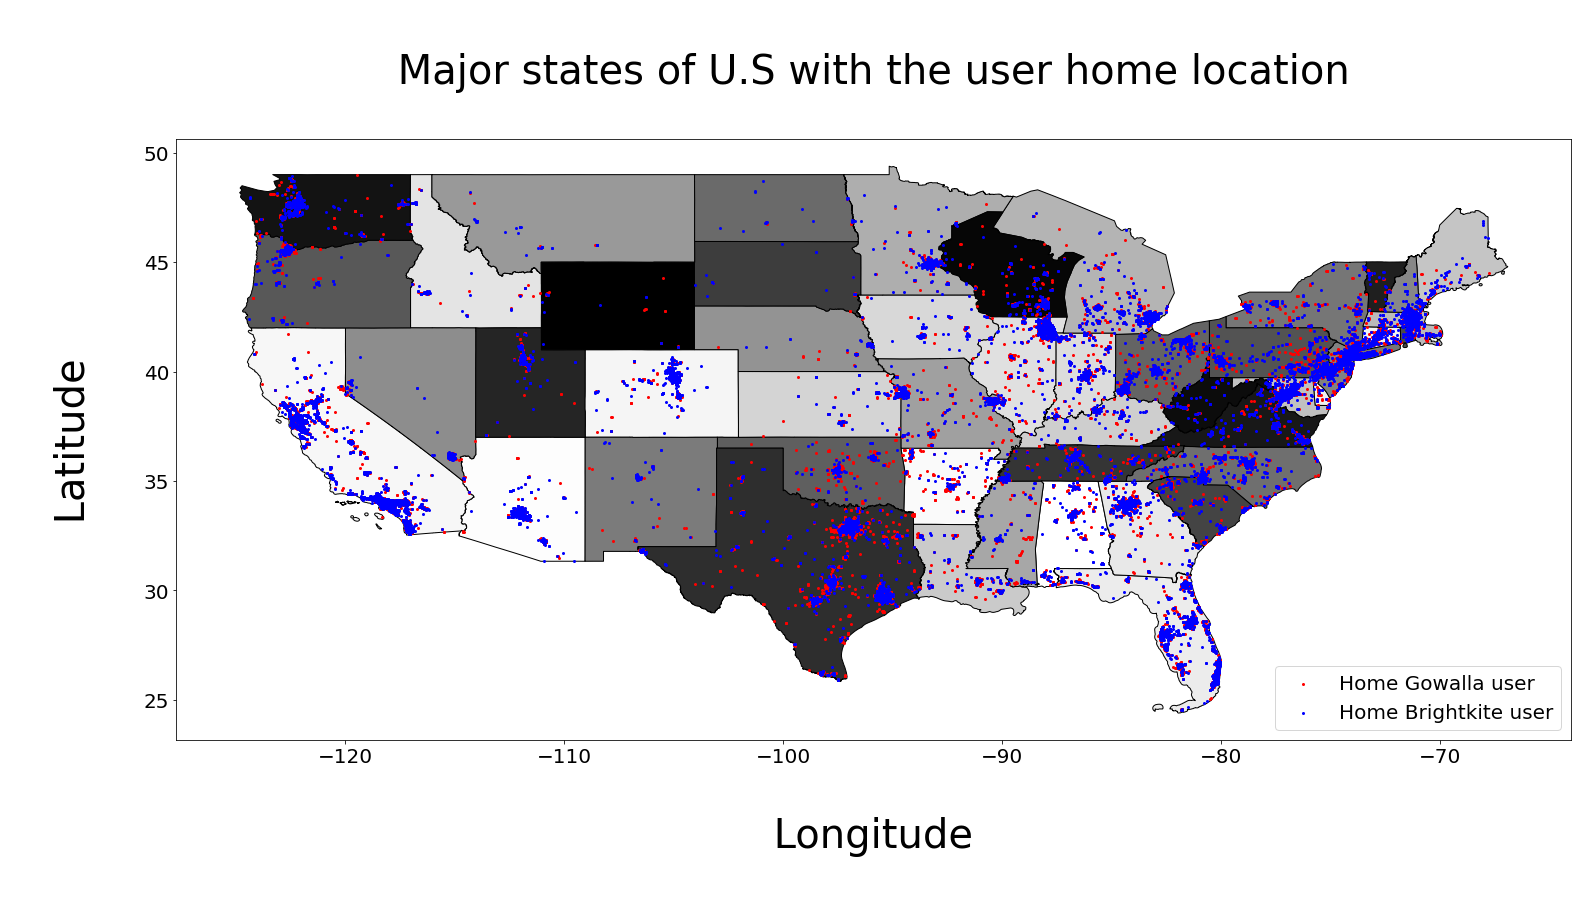

In [45]:
ax = major_states['geometry'].plot(cmap='Greys',figsize=(25, 20),edgecolor='k')
point_in_major_states['geometry'].plot(ax=ax,color='r',markersize =4)
point_in_major_states_b['geometry'].plot(ax=ax,color='b',markersize =4)
plt.title('\n Major states of U.S with the user home location \n ',size=40)
plt.xlabel('\n Longitude \n ',size=40)
plt.ylabel('\n Latitude \n',size=40)
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(['Home Gowalla user','Home Brightkite user'],fontsize=20,loc='lower right')

In [46]:
point_in_major_states.sample(3)

,user,user_house_lat,user_house_long,name,geometry
24823,37162,37.428781,-122.150408,California,POINT (-122.15041 37.42878)


In [47]:
point_in_major_states_b.sample(3)

,user,user_house_lat,user_house_long,name,geometry
24643,27272,38.704282,-77.22776,Virginia,POINT (-77.22776 38.70428)


In [48]:
g_checkin_df.smaple(3)

,user,checkin_time,latitude,longitude,location_id,lat_km,long_km,int_lat,int_long
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847,3343.305415,-9405.541183,133,-376
1,0,2010-10-18T22:17:43Z,30.269103,-97.749395,420315,3346.975790,-9397.965617,133,-375
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637,3345.497199,-9400.590729,133,-376
3,0,2010-10-17T19:26:05Z,30.263418,-97.757597,16516,3346.347196,-9399.298327,133,-375
4,0,2010-10-16T18:50:42Z,30.274292,-97.740523,5535878,3347.549548,-9396.615832,133,-375
...,...,...,...,...,...,...,...,...,...
6442887,196578,2010-06-11T13:32:26Z,51.742988,-0.488065,906885,5721.429146,-33.641493,228,-1
6442888,196578,2010-06-11T13:26:45Z,51.746492,-0.490780,965121,5721.816613,-33.825968,228,-1
6442889,196578,2010-06-11T13:26:34Z,51.741916,-0.496729,1174322,5721.310601,-34.239436,228,-1
6442890,196585,2010-10-08T21:01:49Z,50.105516,8.571525,471724,5540.367274,611.989355,221,24


In [49]:
gdf_checkin = gpd.GeoDataFrame(
    g_checkin_df, geometry=gpd.points_from_xy(g_checkin_df.longitude,g_checkin_df.latitude))
gdf_checkin_b = gpd.GeoDataFrame(
    b_checkin_df, geometry=gpd.points_from_xy(b_checkin_df.longitude,b_checkin_df.latitude))

### Checkin only in the usa made by usa user

In [50]:
gdf_checkin_usa_g = point_in_major_states.merge(gdf_checkin,left_on = ['user'],right_on = ['user'])
gdf_checkin_usa_b = point_in_major_states.merge(gdf_checkin_b,left_on = ['user'],right_on = ['user'])

### Cleaning

In [51]:
COLUMN_TO_DROP = ['location_id','lat_km','long_km','int_lat','int_long','geometry_y']

In [52]:
gdf_checkin_usa_g = gdf_checkin_usa_g.drop(COLUMN_TO_DROP,axis=1)
gdf_checkin_usa_b = gdf_checkin_usa_b.drop(COLUMN_TO_DROP,axis=1)

In [53]:
gdf_checkin_usa_g = gdf_checkin_usa_g.rename({'name':'States of homes'
                                             ,'geometry_x':'geometry homes'},axis=1)
gdf_checkin_usa_b = gdf_checkin_usa_b.rename({'name':'States of homes'
                                             ,'geometry_x':'geometry homes'},axis=1)

In [54]:
(((2235366+3518110)/157779)*57)/60

34.64213995525386

In [55]:
gdf_checkin_usa_g = gpd.GeoDataFrame(
    gdf_checkin_usa_g, geometry=gpd.points_from_xy(gdf_checkin_usa_g.longitude,gdf_checkin_usa_g.latitude))
gdf_checkin_usa_b = gpd.GeoDataFrame(
    gdf_checkin_usa_b, geometry=gpd.points_from_xy(gdf_checkin_usa_b.longitude,gdf_checkin_usa_b.latitude))

In [56]:
from geopandas.tools import sjoin
#check_in_pointInStates_b = sjoin(gdf_checkin_usa_b,states, how='left')

In [57]:
check_in_pointInStates_b = parallelize_dataframe_func(gdf_checkin_usa_b, sjoin_chunk)

In [58]:
check_in_pointInStates_b = check_in_pointInStates_b[['user','user_house_lat','user_house_long','States of homes','geometry homes',
                                                     'checkin_time','latitude','longitude','country','name']]
check_in_pointInStates_b = check_in_pointInStates_b.loc[check_in_pointInStates_b['country']=='USA']

In [59]:
# check_in_pointInStates_g = sjoin(gdf_checkin_usa_g, states, how='left')
check_in_pointInStates_g = parallelize_dataframe_func(gdf_checkin_usa_g, sjoin_chunk)

In [60]:
check_in_pointInStates_g = check_in_pointInStates_g[['user','user_house_lat','user_house_long','States of homes','geometry homes',
                                                     'checkin_time','latitude','longitude','country','name']]
check_in_pointInStates_g = check_in_pointInStates_g.loc[check_in_pointInStates_g['country']=='USA']

In [61]:
check_in_pointInStates_b.sample(3)

,user,user_house_lat,user_house_long,States of homes,geometry homes,checkin_time,latitude,longitude,country,name
1696171,13109,40.832639,-81.479077,Ohio,POINT (-81.47908 40.83264),2010-09-22T19:01:33Z,20.894722,-156.470000,USA,Hawaii
281502,853,40.728488,-73.994308,New York,POINT (-73.99431 40.72849),2010-08-01T07:07:33Z,33.926856,-118.370997,USA,California
468105,2001,27.777527,-82.659241,Florida,POINT (-82.65924 27.77753),2008-07-03T04:23:13Z,38.890390,-77.084145,USA,Virginia


In [62]:
check_in_pointInStates_g.sample(3)

,user,user_house_lat,user_house_long,States of homes,geometry homes,checkin_time,latitude,longitude,country,name
1651668,21389,30.268026,-97.740343,Texas,POINT (-97.74034 30.26803),2010-03-16T01:30:48Z,30.264977,-97.746139,USA,Texas
3176118,125177,42.125145,-88.002458,Illinois,POINT (-88.00246 42.12515),2010-10-17T15:52:17Z,42.178213,-87.998042,USA,Illinois
2456150,60002,42.384663,-72.543674,Massachusetts,POINT (-72.54367 42.38466),2009-12-11T17:31:23Z,42.358150,-72.549894,USA,Massachusetts


In [64]:
check_in_pointInStates_b['date'] =\
check_in_pointInStates_b['checkin_time'].astype(str).parallel_apply(lambda x: np.datetime64(x.split("T", 1)[0]))

In [65]:
check_in_pointInStates_g['date'] =\
check_in_pointInStates_g['checkin_time'].astype(str).parallel_apply(lambda x: np.datetime64(x.split("T", 1)[0]))

In [66]:
ds_tmin = xr.open_dataset("./InputData/coarse_tmmn.nc")
ds_tmax = xr.open_dataset("./InputData/coarse_tmmx.nc")
ds_pr = xr.open_dataset("./InputData/coarse_pr.nc")

In [67]:
check_in_pointInStates_b["tmin"] =\
check_in_pointInStates_b.parallel_apply(
    lambda df : ds_tmin.sel(day=df.date, lon=df.longitude,
                            lat=df.latitude, method="nearest",
                            tolerance=400).get('air_temperature').data.ravel()[0],
    axis=1)

In [68]:
check_in_pointInStates_b["tmax"] =\
check_in_pointInStates_b.parallel_apply(
    lambda df : ds_tmax.sel(day=df.date, lon=df.longitude,
                            lat=df.latitude, method="nearest",
                            tolerance=400).get('air_temperature').data.ravel()[0],
    axis=1)

In [69]:
check_in_pointInStates_b["pr"] =\
check_in_pointInStates_b.parallel_apply(
    lambda df : ds_pr.sel(day=df.date, lon=df.longitude,
                            lat=df.latitude, method="nearest",
                            tolerance=400).get('precipitation_amount').data.ravel()[0],
    axis=1)

In [91]:
check_in_pointInStates_b.sample(3)

,user,user_house_lat,user_house_long,States of homes,geometry homes,checkin_time,latitude,longitude,country,name,date,tmin,tmax,pr
1789083,15679,42.004020,-91.673368,Iowa,POINT (-91.67337 42.00402),2009-11-27T16:21:16Z,38.878034,-97.619032,USA,Kansas,2009-11-27,270.299988,289.600006,0.0
1625202,11587,37.391467,-122.022124,California,POINT (-122.02212 37.39147),2009-06-30T04:15:37Z,42.071729,-75.967996,USA,New York,2009-06-30,286.799988,295.299988,9.0
1180506,7532,30.265064,-97.740378,Texas,POINT (-97.74038 30.26506),2009-04-16T00:34:20Z,34.147785,-118.144515,USA,California,2009-04-16,278.299988,292.799988,0.0


In [71]:
check_in_pointInStates_g["tmin"] =\
check_in_pointInStates_g.parallel_apply(
    lambda df : ds_tmin.sel(day=df.date, lon=df.longitude,
                            lat=df.latitude, method="nearest",
                            tolerance=400).get('air_temperature').data.ravel()[0],
    axis=1)

In [72]:
check_in_pointInStates_g["tmax"] =\
check_in_pointInStates_g.parallel_apply(
    lambda df : ds_tmax.sel(day=df.date, lon=df.longitude,
                            lat=df.latitude, method="nearest",
                            tolerance=400).get('air_temperature').data.ravel()[0],
    axis=1)

In [73]:
check_in_pointInStates_g["pr"] =\
check_in_pointInStates_g.parallel_apply(
    lambda df : ds_pr.sel(day=df.date, lon=df.longitude,
                            lat=df.latitude, method="nearest",
                            tolerance=400).get('precipitation_amount').data.ravel()[0],
    axis=1)

In [74]:
check_in_pointInStates_g.sample(5)

,user,user_house_lat,user_house_long,States of homes,geometry homes,checkin_time,latitude,longitude,country,name,date,tmin,tmax,pr
2671750,79251,37.162747,-93.249949,Missouri,POINT (-93.24995 37.16275),2010-09-30T21:17:26Z,37.148580,-93.239133,USA,Missouri,2010-09-30,280.100006,296.500000,0.0
2747688,90131,29.543397,-95.131387,Texas,POINT (-95.13139 29.54340),2010-05-16T16:20:08Z,29.648732,-95.113934,USA,Texas,2010-05-16,293.799988,302.600006,0.0
1224530,10440,41.715923,-88.298020,Illinois,POINT (-88.29802 41.71592),2010-03-16T17:34:01Z,41.705971,-87.987160,USA,Illinois,2010-03-16,272.299988,289.500000,0.0
363492,1732,41.246431,-96.015587,Nebraska,POINT (-96.01559 41.24643),2010-07-23T16:26:53Z,44.947495,-93.096417,USA,Minnesota,2010-07-23,290.500000,301.799988,10.1
1471856,15881,37.975429,-87.565607,Indiana,POINT (-87.56561 37.97543),2010-06-03T20:23:37Z,37.979229,-87.566913,USA,Indiana,2010-06-03,293.000000,304.100006,0.0


In [96]:
check_in_pointInStates_b.dropna(inplace=True)
check_in_pointInStates_g.dropna(inplace=True)

In [75]:
check_in_pointInStates_b.to_csv('home_and_checkin_with_states_bright.csv')
check_in_pointInStates_g.to_csv('home_and_checkin_with_states_gowalla.csv')